In [3]:
import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

In [102]:
""" Load Image Data
"""
data_dir = 'data/'

def load_gray_image(image_path):
    return np.array(Image.open(image_path).convert('L'))
 
# load all images
image_cana = load_gray_image(data_dir + '/cana.jpg')
image_leaf = load_gray_image(data_dir + '/leaf.jpg')
image_lamp = load_gray_image(data_dir + '/lamp.jpg')
image_fruit = load_gray_image(data_dir + '/fruit.jpg')
image_img335 = load_gray_image(data_dir + '/img335.jpg')

In [107]:
def plot_gray_images(images, title='NoTitle', imnames=[]):
    """Plot images side by side
    """
    n = len(images)
    
    if not imnames:
        imnames = [''] * n

    fig, axes = plt.subplots(2,3, figsize=(20,10))
    for i, image in enumerate(images):
        ax = axes[i%2, i%3]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(imnames[i])
    fig.delaxes(axes[1,2])

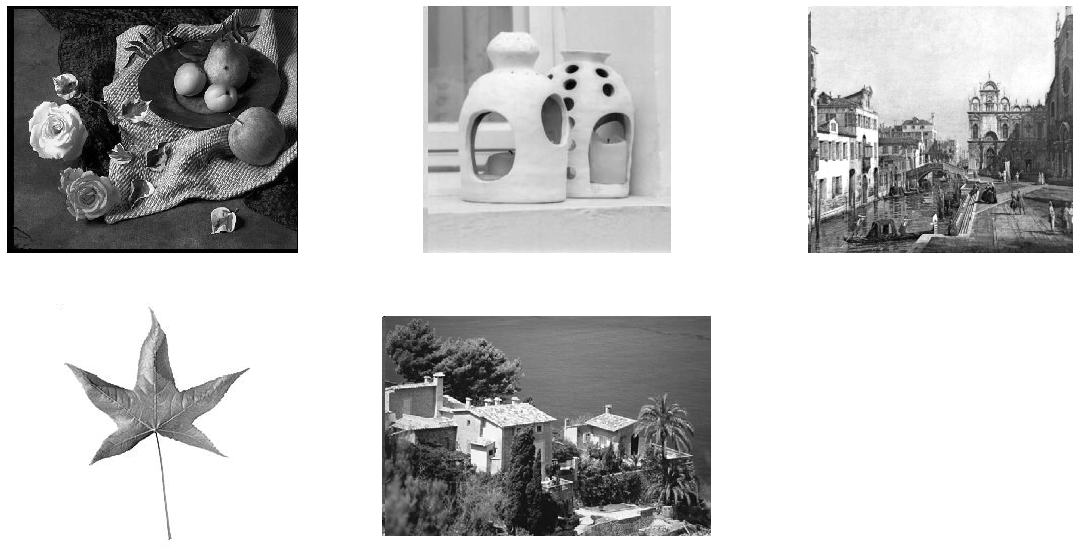

In [108]:
plot_gray_images([image_fruit, image_img335, image_cana, image_leaf, image_lamp])

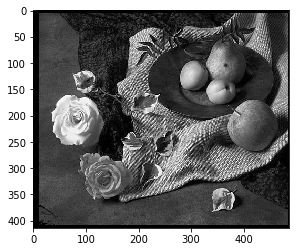

In [247]:
plt.imshow(image_fruit, cmap='gray')

## Helpers: Image Operations

### Convolution Operations

In [96]:
def convolution(image, kernel, average=False):
    """ Perform convolution operation for a given kernel
    """
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(image.shape)

    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)

    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
    padded_height, padded_width = padded_image.shape[:2]
    padded_image[pad_height:padded_height - pad_height, pad_width:padded_width - pad_width] = image

    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
    return output

### Gaussian Kernel Operations

In [117]:
import math


def dnorm(x, mu, sd):
    const_term = 1 / (np.sqrt(2 * np.pi) * sd)
    power_term = np.exp(-np.power((x - mu) / sd, 2) / 2)
    return  const_term * power_term 


def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)

    for i in range(size):
        # calculate gaussian values at row ith
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)

    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
    kernel_2D *= 1.0 / kernel_2D.max()

    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel ({0} X {1})".format(size, size))
        plt.show()

    return kernel_2D


def gaussian_smoothing(image, kernel_size, verbose=False):
    """ Perform gaussian smoothing operation
    """
    kernel = gaussian_kernel(kernel_size, sigma=math.sqrt(kernel_size),
                             verbose=verbose)
    return convolution(image, kernel, average=True)


### Edge Extraction Operations

In [125]:
def edge_detection(image, kernel, convert_to_degree=False):
    """ Perform sobel edge detection
    """
    kernel_y = np.flip(kernel.T, axis=0)

    new_image_x = convolution(image, kernel, verbose)
    new_image_y = convolution(image, kernel_y, verbose)
    
    gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))
    gradient_magnitude *= 255.0 / gradient_magnitude.max()
    gradient_direction = np.arctan2(new_image_y, new_image_x)

    if convert_to_degree:
        gradient_direction = np.rad2deg(gradient_direction)
        gradient_direction += 180

    return gradient_magnitude, gradient_direction


def sobel_edge_detection(image, convert_to_degree=False, verbose=False):
    """ Perform sobel edge detection
    """
    sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    gradient_magnitude, gradient_direction = edge_detection(
        image, sobel_kernel_x, convert_to_degree)

    if verbose:
        plt.imshow(gradient_magnitude, cmap='gray')
        plt.title('Gradient Magnitude')
        plt.show()

    return gradient_magnitude, gradient_direction

### Non Max Suppression operation

In [99]:
PI = 180

def non_max_suppression(gradient_magnitude, gradient_direction, verbose=False):
    """ Apply non-maximum supression
    """
    
    image_row, image_col = gradient_magnitude.shape
    output = np.zeros(gradient_magnitude.shape)

    for row in range(1, image_row - 1):
        for col in range(1, image_col - 1):
            direction = gradient_direction[row, col]

            # (0 - PI/8 and 15PI/8 - 2PI)
            if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
                before_pixel = gradient_magnitude[row, col - 1]
                after_pixel = gradient_magnitude[row, col + 1]

            elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
                before_pixel = gradient_magnitude[row + 1, col - 1]
                after_pixel = gradient_magnitude[row - 1, col + 1]

            elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
                before_pixel = gradient_magnitude[row - 1, col]
                after_pixel = gradient_magnitude[row + 1, col]

            else:
                before_pixel = gradient_magnitude[row - 1, col - 1]
                after_pixel = gradient_magnitude[row + 1, col + 1]

            if (gradient_magnitude[row, col] >= before_pixel and
                gradient_magnitude[row, col] >= after_pixel):
                # check if this is maximum edge
                output[row, col] = gradient_magnitude[row, col]

    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Non Max Suppression")
        plt.show()

    return output

### Hysterisis and Double Thresholding

In [131]:
def double_threshold(image, low, high, weak=50, verbose=False):
    """ Perform double thresholding for image with pixel range [0,255].

    Mark weak edge {low < x < high} with certain value
    Mark strong edge {x > high} with certain value
    """
    output = np.zeros(image.shape)
    strong = 255  # mark strong pixel with this value

    strong_row, strong_col = np.where(image >= high)
    weak_row, weak_col = np.where((image <= high) & (image >= low))

    output[strong_row, strong_col] = strong
    output[weak_row, weak_col] = weak

    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("threshold")
        plt.show()

    return output

In [101]:
def hysteresis(image, weak=50):
    """ Perform Hysterisis Thresholding on edged image
    """
    image_row, image_col = image.shape[:2]
    top_to_bottom = image.copy()

    for row in range(1, image_row):
        for col in range(1, image_col):
            if top_to_bottom[row, col] == weak:
                if top_to_bottom[row, col + 1] == 255 or top_to_bottom[row, col - 1] == 255 or top_to_bottom[row - 1, col] == 255 or top_to_bottom[
                    row + 1, col] == 255 or top_to_bottom[
                    row - 1, col - 1] == 255 or top_to_bottom[row + 1, col - 1] == 255 or top_to_bottom[row - 1, col + 1] == 255 or top_to_bottom[
                    row + 1, col + 1] == 255:
                    top_to_bottom[row, col] = 255
                else:
                    top_to_bottom[row, col] = 0

    bottom_to_top = image.copy()

    for row in range(image_row - 1, 0, -1):
        for col in range(image_col - 1, 0, -1):
            if bottom_to_top[row, col] == weak:
                if bottom_to_top[row, col + 1] == 255 or bottom_to_top[row, col - 1] == 255 or bottom_to_top[row - 1, col] == 255 or bottom_to_top[
                    row + 1, col] == 255 or bottom_to_top[
                    row - 1, col - 1] == 255 or bottom_to_top[row + 1, col - 1] == 255 or bottom_to_top[row - 1, col + 1] == 255 or bottom_to_top[
                    row + 1, col + 1] == 255:
                    bottom_to_top[row, col] = 255
                else:
                    bottom_to_top[row, col] = 0

    right_to_left = image.copy()

    for row in range(1, image_row):
        for col in range(image_col - 1, 0, -1):
            if right_to_left[row, col] == weak:
                if right_to_left[row, col + 1] == 255 or right_to_left[row, col - 1] == 255 or right_to_left[row - 1, col] == 255 or right_to_left[
                    row + 1, col] == 255 or right_to_left[
                    row - 1, col - 1] == 255 or right_to_left[row + 1, col - 1] == 255 or right_to_left[row - 1, col + 1] == 255 or right_to_left[
                    row + 1, col + 1] == 255:
                    right_to_left[row, col] = 255
                else:
                    right_to_left[row, col] = 0

    left_to_right = image.copy()

    for row in range(image_row - 1, 0, -1):
        for col in range(1, image_col):
            if left_to_right[row, col] == weak:
                if left_to_right[row, col + 1] == 255 or left_to_right[row, col - 1] == 255 or left_to_right[row - 1, col] == 255 or left_to_right[
                    row + 1, col] == 255 or left_to_right[
                    row - 1, col - 1] == 255 or left_to_right[row + 1, col - 1] == 255 or left_to_right[row - 1, col + 1] == 255 or left_to_right[
                    row + 1, col + 1] == 255:
                    left_to_right[row, col] = 255
                else:
                    left_to_right[row, col] = 0

    final_image = top_to_bottom + bottom_to_top + right_to_left + left_to_right
    final_image[final_image > 255] = 255

    return final_image

## Step by Step: Canny Edge Detector

For exploration, we will use `image_fruit` which is a fruit image in gray scale format

In [113]:
image = image_fruit

### 1. Gaussian Smoothing

In [243]:
# parameters
kernel_size = 9

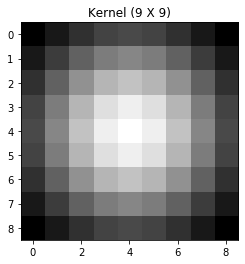

In [244]:
# perform gaussian smoothing
smooth = gaussian_smoothing(image, kernel_size, verbose=True)

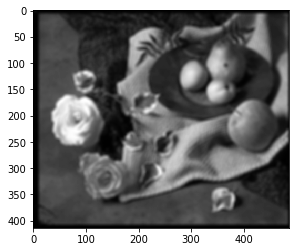

In [245]:
plt.imshow(smooth, cmap='gray');

### 2. Edge Extraction

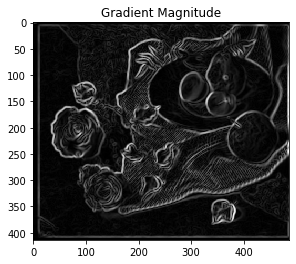

In [186]:
use_degree = True

# perform sobel edge detection
gradient_magnitude, gradient_direction = sobel_edge_detection(smooth, use_degree, verbose=True)

### 3. Non-max Suppression

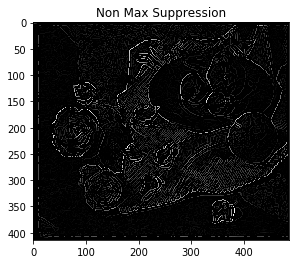

In [187]:
# perform non-max suppression
maxsup = non_max_suppression(gradient_magnitude, gradient_direction, verbose=True)

### 4. Double Thresholding

In [208]:
# parameters
low_thresh = 20      # threshold for weak edge
high_thresh = 70    # threshold for strong edge
weak = 50           # mark weak edge with value=50

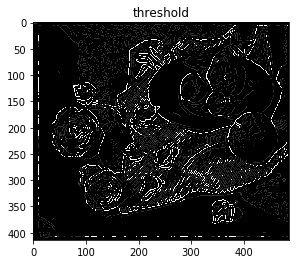

In [209]:
edged_image = double_threshold(maxsup, low_thresh, high_thresh, weak, verbose=True)

### 5. Hysterisis Thresholding

In [210]:
edged_image = hysteresis(edged_image, weak)

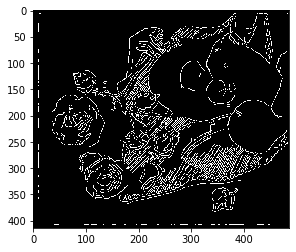

In [211]:
plt.imshow(edged_image, cmap='gray')

In [212]:
import cv2
edges = cv2.Canny(image,50,200)

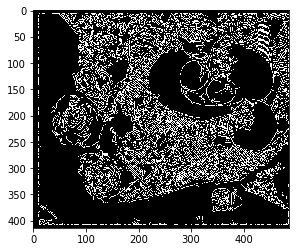

In [197]:
plt.imshow(edges, cmap='gray')

### Putting All Together

In [215]:
def canny_edge_detector(image, low_thresh=20, high_thresh=80):
    # parameters
    kernel_size = 5
    use_degree = True
    
    # perform gaussian smoothing
    smooth = gaussian_smoothing(image, kernel_size, verbose=True)
    
    # perform sobel edge detection
    gradient_magnitude, gradient_direction = sobel_edge_detection(smooth, use_degree, verbose=True)
    
    # perform non-max suppression
    maxsup = non_max_suppression(gradient_magnitude, gradient_direction, verbose=True)
    
    # perform double thresholding
    edged_image = double_threshold(maxsup, low_thresh, high_thresh, weak, verbose=True)
    
    # perform hyteresis threholding
    edged_image = hysteresis(edged_image, weak)
    
    plt.imshow(edged_image, cmap='gray')
    plt.title('Hysteresis (Final)')

#### Image Fruit

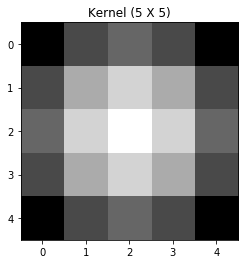

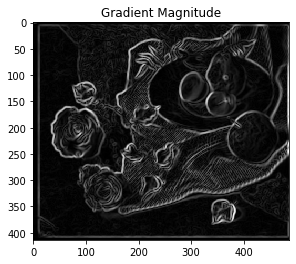

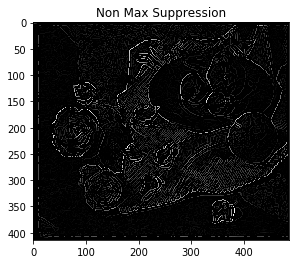

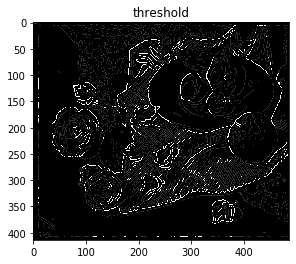

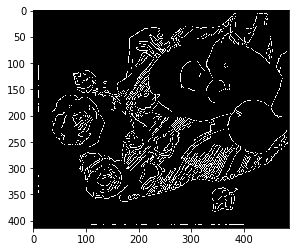

In [216]:
canny_edge_detector(image_fruit)

#### Image Cana

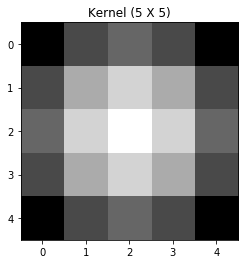

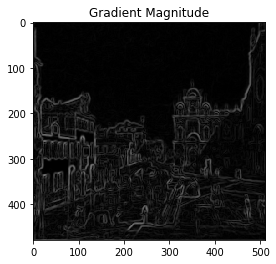

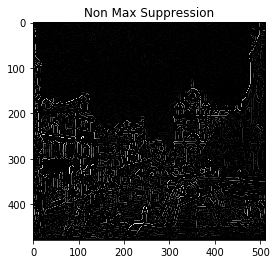

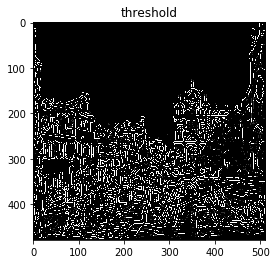

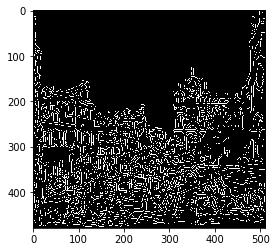

In [238]:
# canny edge detection
canny_edge_detector(image_cana, low_thresh=10, high_thresh=15)

#### Image Leaf

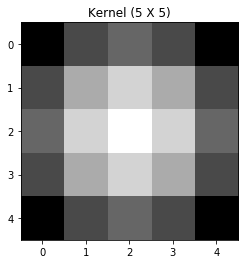

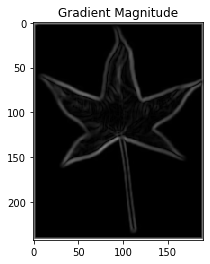

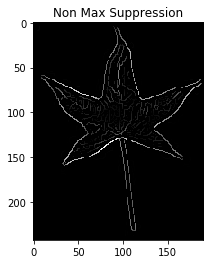

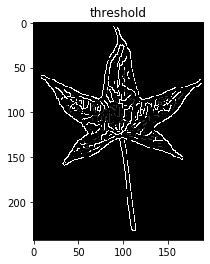

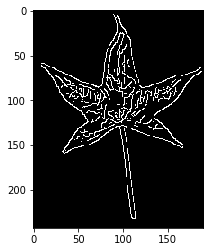

In [227]:
# canny edge detection
canny_edge_detector(image_leaf, low_thresh=5, high_thresh=10)

#### Image IMG335

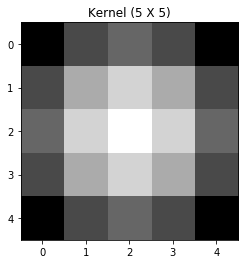

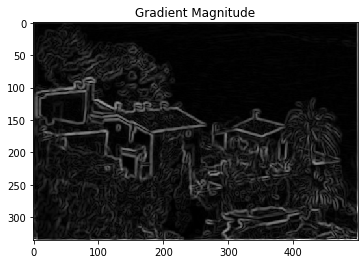

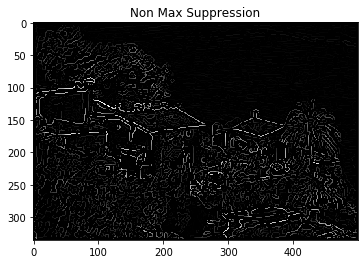

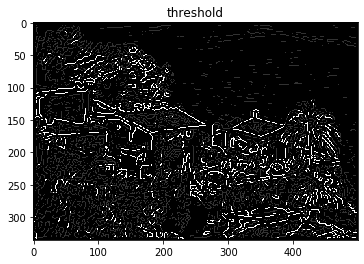

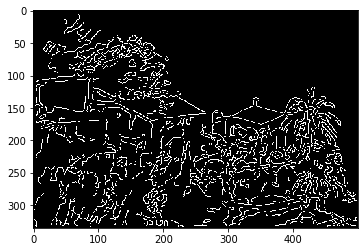

In [235]:
# canny edge 335
canny_edge_detector(image_img335, low_thresh=5, high_thresh=40)

#### Image Lamp

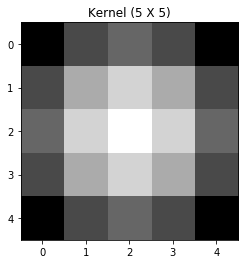

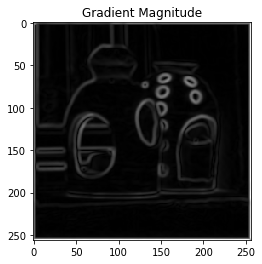

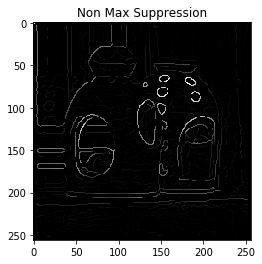

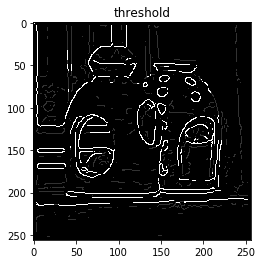

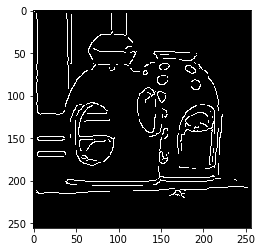

In [233]:
# canny edge lamp
canny_edge_detector(image_lamp, low_thresh=5, high_thresh=15)

### First derivative and Second derivative Edge Detector

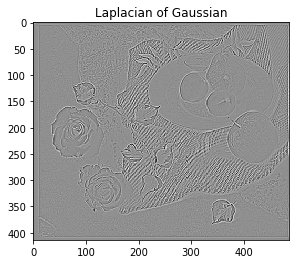

In [242]:
import cv2
import matplotlib.pyplot as plt

# Apply gaussian blur
blur_img = cv2.GaussianBlur(image_fruit, (3, 3), 0)

# Positive Laplacian Operator
laplacian = cv2.Laplacian(blur_img, cv2.CV_64F)

plt.figure()
plt.title('Laplacian of Gaussian')
plt.imsave('shapes-lap.png', laplacian, cmap='gray', format='png')
plt.imshow(laplacian, cmap='gray')
plt.show()

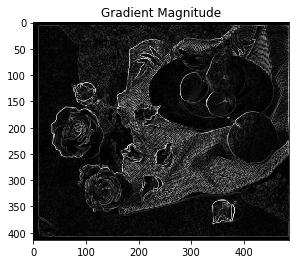

In [241]:
use_degree = True

# perform sobel edge detection
gradient_magnitude, gradient_direction = sobel_edge_detection(image_fruit, use_degree, verbose=True)